<a href="https://colab.research.google.com/github/nainsi20/Creditcard-fraud-detection/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn
!pip install xgboost
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import layers, models

In [4]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [5]:
df = pd.read_csv("creditcard.csv")

In [6]:
# Display first few rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Checking for missing values
df.isnull().sum()

# Feature Scaling
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df.drop(['Amount', 'Time'], axis=1, inplace=True)

# Check class distribution
print(df['Class'].value_counts())

# SMOTE to handle class imbalance
X = df.drop('Class', axis=1)
y = df['Class']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)


Class
0    284315
1       492
Name: count, dtype: int64


In [8]:
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(X_train)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)  # Convert anomaly score to binary class

# Evaluation
print("Isolation Forest Evaluation")
print(classification_report(y_test, y_pred_iso))


Isolation Forest Evaluation
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     85149
           1       0.98      0.00      0.00     85440

    accuracy                           0.50    170589
   macro avg       0.74      0.50      0.34    170589
weighted avg       0.74      0.50      0.33    170589



In [10]:
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.001)
oc_svm.fit(X_train)
y_pred_svm = oc_svm.predict(X_test)
y_pred_svm = np.where(y_pred_svm == 1, 0, 1)

# Evaluation
print("One-Class SVM Evaluation")
print(classification_report(y_test, y_pred_svm))

One-Class SVM Evaluation
              precision    recall  f1-score   support

           0       0.50      0.99      0.67     85149
           1       0.69      0.02      0.04     85440

    accuracy                           0.51    170589
   macro avg       0.60      0.51      0.35    170589
weighted avg       0.60      0.51      0.35    170589



In [11]:
# Autoencoder Model
input_dim = X_train.shape[1]
autoencoder = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict Reconstruction Loss
reconstructions = autoencoder.predict(X_test)
reconstruction_loss = np.mean(np.abs(reconstructions - X_test), axis=1)
threshold = np.percentile(reconstruction_loss, 99.5)
y_pred_auto = (reconstruction_loss > threshold).astype(int)

# Evaluation
print("Autoencoder Evaluation")
print(classification_report(y_test, y_pred_auto))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 13.4236 - val_loss: 12.9994
Epoch 2/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 13.2201 - val_loss: 12.9873
Epoch 3/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 13.2395 - val_loss: 12.9744
Epoch 4/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 13.1571 - val_loss: 12.9714
Epoch 5/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 13.2113 - val_loss: 12.9670
Epoch 6/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 13.1414 - val_loss: 12.9657
Epoch 7/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 13.2287 - val_loss: 12.9647
Epoch 8/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 13.2062 - val_loss: 12.9602
Epoch 9/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 13.2667 - val_loss: 12.9594
Epoch 10/10
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 13.2990 - val_loss: 12.9589
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Autoencoder Evaluation
              precision

Random Forest Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



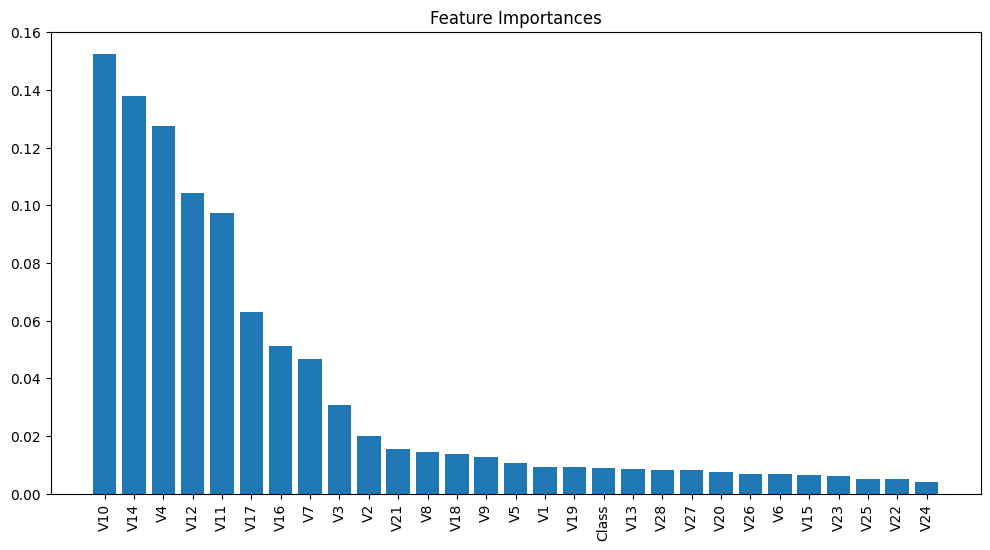

In [12]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Random Forest Evaluation")
print(classification_report(y_test, y_pred_rf))

# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), df.columns[indices], rotation=90)
plt.show()


In [13]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluation
print("XGBoost Evaluation")
print(classification_report(y_test, y_pred_xgb))


XGBoost Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



In [14]:
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=100, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluation
print("Neural Network Evaluation")
print(classification_report(y_test, y_pred_mlp))


Neural Network Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



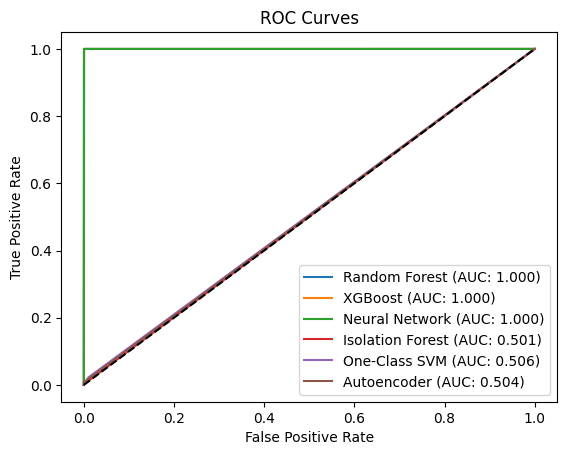

              Model  Precision    Recall  F1-Score  Accuracy       AUC
0     Random Forest   0.999754  1.000000  0.999877  0.999877  0.999877
1           XGBoost   0.999403  1.000000  0.999702  0.999701  0.999701
2    Neural Network   0.999462  0.999871  0.999667  0.999666  0.999666
3  Isolation Forest   0.983333  0.002072  0.004135  0.500167  0.501018
4     One-Class SVM   0.689331  0.022308  0.043218  0.505285  0.506110
5       Autoencoder   0.995769  0.008263  0.016390  0.503268  0.504114


In [15]:
# Generate ROC Curves for each model
models = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Neural Network': y_pred_mlp,
    'Isolation Forest': y_pred_iso,
    'One-Class SVM': y_pred_svm,
    'Autoencoder': y_pred_auto
}

for model, y_pred in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{model} (AUC: {roc_auc_score(y_test, y_pred):.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Create performance summary table
results = []
for model, y_pred in models.items():
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    results.append([model, precision, recall, f1, accuracy, auc])

results_df = pd.DataFrame(results, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC'])
print(results_df)


In [16]:
# Example of Hybrid Approach - combining Isolation Forest and Random Forest
y_pred_hybrid = np.where(y_pred_iso == 1, 1, y_pred_rf)  # If Isolation Forest flags as fraud, treat as fraud

# Evaluation
print("Hybrid Model Evaluation")
print(classification_report(y_test, y_pred_hybrid))

# Add hybrid model to results and compare
results.append(['Hybrid Model', precision_score(y_test, y_pred_hybrid), recall_score(y_test, y_pred_hybrid),
                f1_score(y_test, y_pred_hybrid), accuracy_score(y_test, y_pred_hybrid), roc_auc_score(y_test, y_pred_hybrid)])

results_df = pd.DataFrame(results, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC'])
print(results_df)


Hybrid Model Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

              Model  Precision    Recall  F1-Score  Accuracy       AUC
0     Random Forest   0.999754  1.000000  0.999877  0.999877  0.999877
1           XGBoost   0.999403  1.000000  0.999702  0.999701  0.999701
2    Neural Network   0.999462  0.999871  0.999667  0.999666  0.999666
3  Isolation Forest   0.983333  0.002072  0.004135  0.500167  0.501018
4     One-Class SVM   0.689331  0.022308  0.043218  0.505285  0.506110
5       Autoencoder   0.995769  0.008263  0.016390  0.503268  0.504114
6      Hybrid Model   0.999719  1.000000  0.999860  0.999859  0.999859


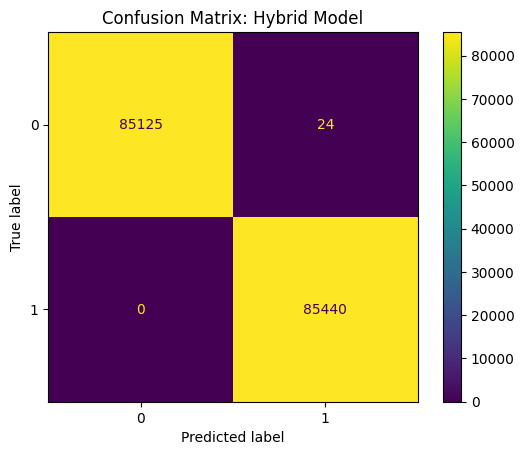

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for Hybrid Model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_hybrid)
plt.title("Confusion Matrix: Hybrid Model")
plt.show()


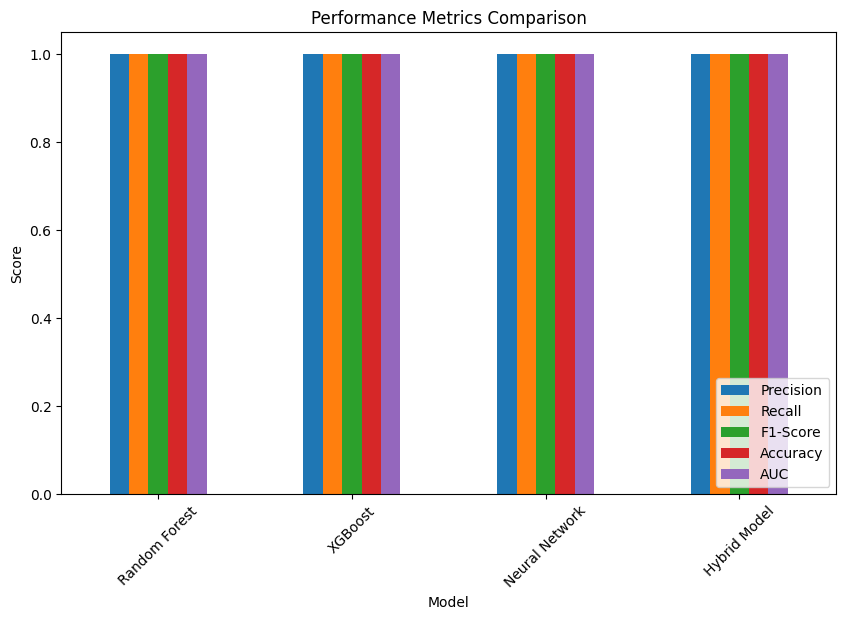

In [19]:
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC']
models = ['Random Forest', 'XGBoost', 'Neural Network', 'Hybrid Model']

# Assuming you have the 'results_df' DataFrame with all model results
results_df.set_index('Model')[metrics].loc[models].plot(kind='bar', figsize=(10,6))
plt.title('Performance Metrics Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()


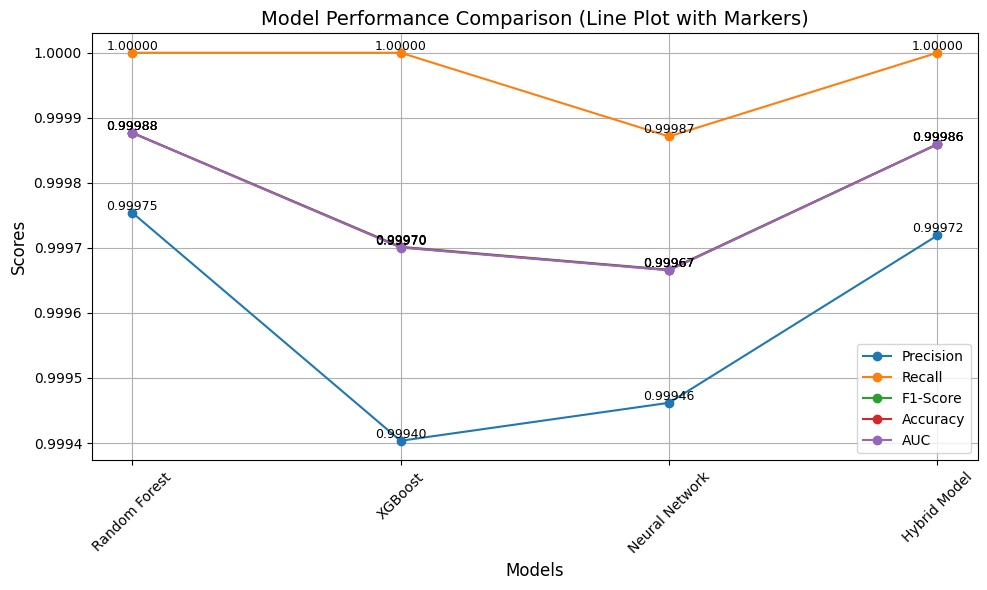

In [22]:
import matplotlib.pyplot as plt

# Select the relevant models and metrics for comparison
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC']
models = ['Random Forest', 'XGBoost', 'Neural Network', 'Hybrid Model']

# Extracting the values for the selected models
results_df_selected = results_df.set_index('Model').loc[models, metrics]

# Plotting the line chart with markers
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(models, results_df_selected[metric], marker='o', label=metric)

# Annotate the values directly on the plot
for model in models:
    for metric in metrics:
        plt.text(model, results_df_selected.loc[model, metric], f"{results_df_selected.loc[model, metric]:.5f}",
                 horizontalalignment='center', verticalalignment='bottom', fontsize=9)

# Formatting the plot
plt.title("Model Performance Comparison (Line Plot with Markers)", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
